In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub


In [2]:
# kagglehub.login()
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# playground_series_s5e4_path = kagglehub.competition_download('playground-series-s5e4')

# print('Data source import complete.')

In [3]:
playground_series_s5e4_path = '/home/kt/.cache/kagglehub/competitions/playground-series-s5e4'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge,RidgeCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error

# Load Data

In [5]:
df = pd.read_csv(f'{playground_series_s5e4_path}/train.csv')
df_test = pd.read_csv(f'{playground_series_s5e4_path}/test.csv')


In [6]:
# Check if Podcast_Name sets are the same between train and test datasets
train_podcasts = set(df['Podcast_Name'])
test_podcasts = set(df_test['Podcast_Name'])

print(f"Number of unique podcasts in train: {len(train_podcasts)}")
print(f"Number of unique podcasts in test: {len(test_podcasts)}")

# Check if they are identical
if train_podcasts == test_podcasts:
    print("The podcast sets are identical between train and test datasets.")
else:
    print("The podcast sets are different between train and test datasets.")
    
    # Find differences
    only_in_train = train_podcasts - test_podcasts
    only_in_test = test_podcasts - train_podcasts
    
    print(f"Podcasts only in train: {len(only_in_train)}")
    print(f"Podcasts only in test: {len(only_in_test)}")
   

Number of unique podcasts in train: 48
Number of unique podcasts in test: 48
The podcast sets are identical between train and test datasets.


In [7]:
# Extract rows where Podcast_Name is 'Educational Nuggets'
df_educational = df[df['Podcast_Name'] == 'Educational Nuggets']
df_test_educational = df_test[df_test['Podcast_Name'] == 'Educational Nuggets']

print(f"Number of Educational Nuggets episodes in train: {len(df_educational)}")
print(f"Number of Educational Nuggets episodes in test: {len(df_test_educational)}")


Number of Educational Nuggets episodes in train: 12245
Number of Educational Nuggets episodes in test: 3963


In [8]:
# Extract rows where Podcast_Name is 'Educational Nuggets'
df_sound_waves = df[df['Podcast_Name'] == 'Sound Waves']
df_test_sound_waves = df_test[df_test['Podcast_Name'] == 'Sound Waves']

print(f"Number of Sound Waves episodes in train: {len(df_sound_waves)}")
print(f"Number of Sound Waves episodes in test: {len(df_test_sound_waves)}")


Number of Sound Waves episodes in train: 13928
Number of Sound Waves episodes in test: 4689


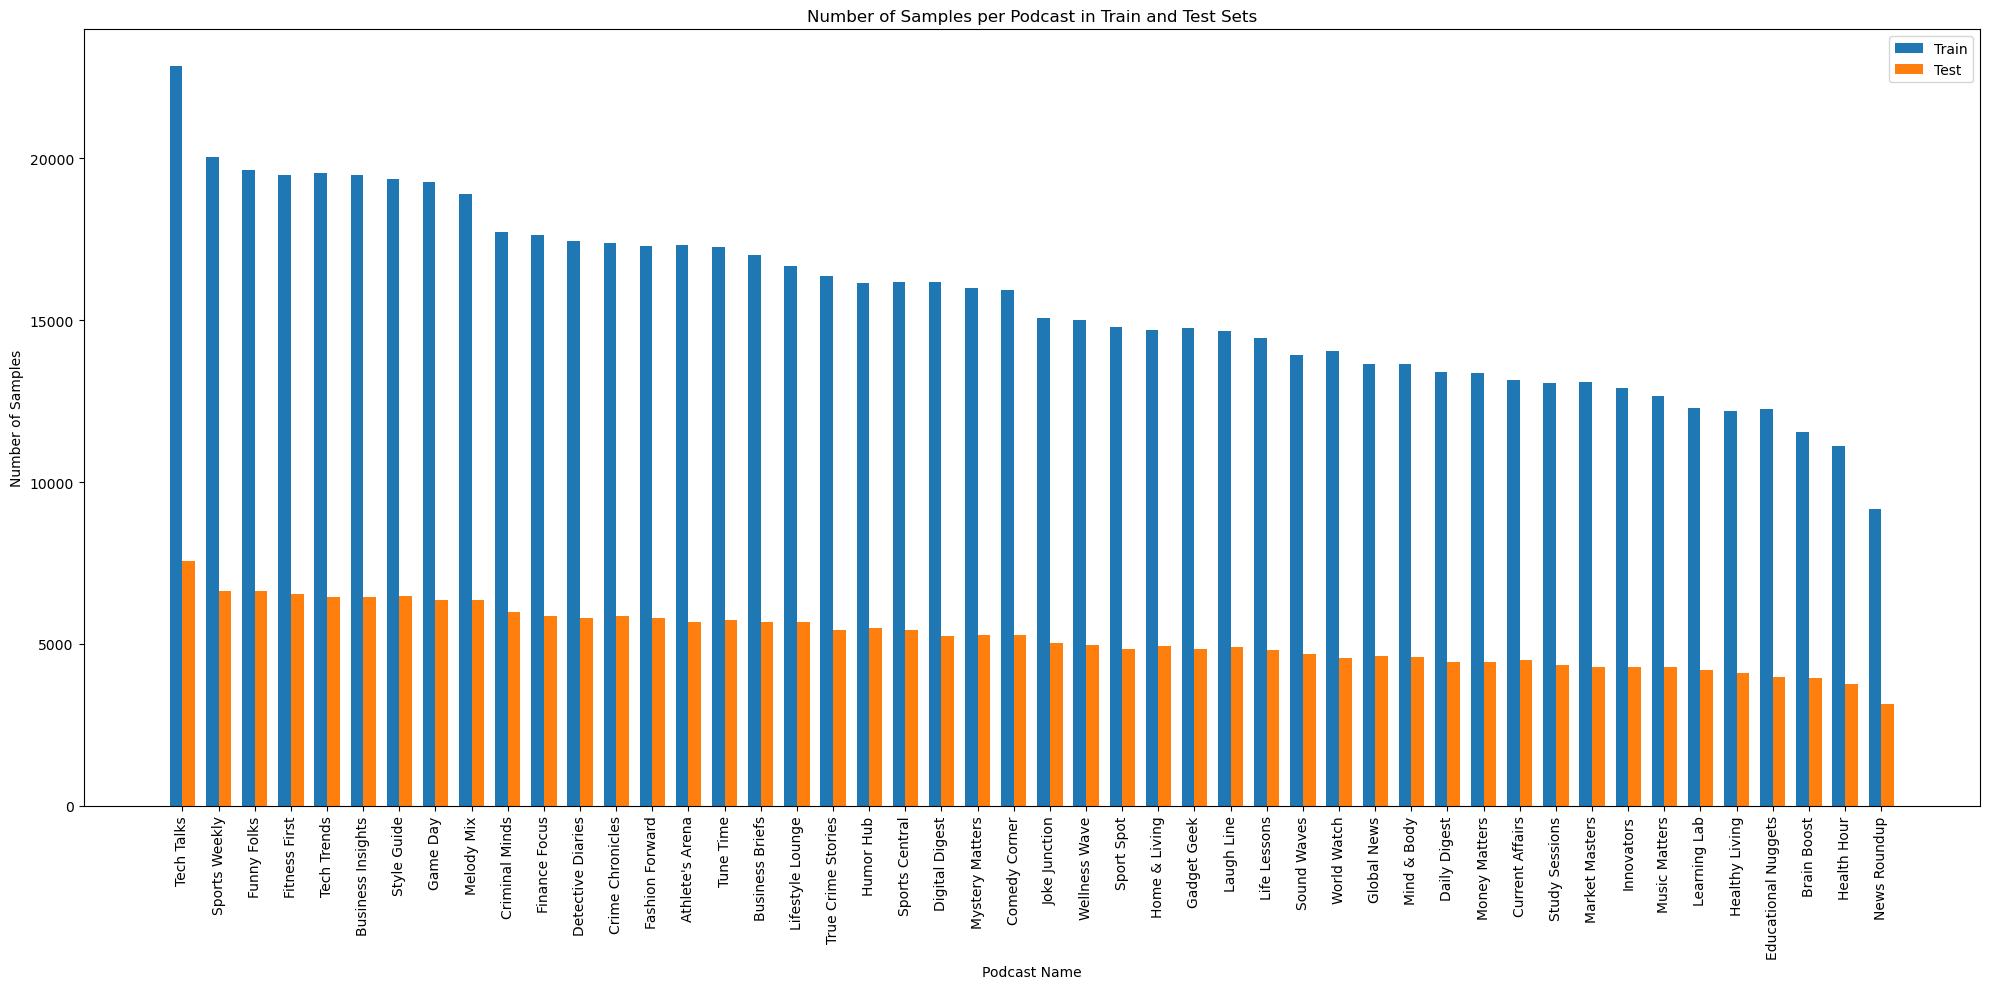

Top 10 podcasts by total sample count:
        Podcast_Name  Train_Count  Test_Count  Total
0         Tech Talks        22847        7553  30400
1      Sports Weekly        20053        6633  26686
2        Funny Folks        19635        6621  26256
3      Fitness First        19488        6543  26031
4        Tech Trends        19549        6446  25995
5  Business Insights        19480        6448  25928
6        Style Guide        19364        6469  25833
7           Game Day        19272        6345  25617
8         Melody Mix        18889        6357  25246
9     Criminal Minds        17735        5980  23715


In [9]:
# Get count of each podcast in train and test datasets
train_podcast_counts = df['Podcast_Name'].value_counts().reset_index()
train_podcast_counts.columns = ['Podcast_Name', 'Train_Count']

test_podcast_counts = df_test['Podcast_Name'].value_counts().reset_index()
test_podcast_counts.columns = ['Podcast_Name', 'Test_Count']

# Merge the counts
merged_counts = train_podcast_counts.merge(test_podcast_counts, on='Podcast_Name', how='outer').fillna(0)

# Sort by total count (train + test)
merged_counts['Total'] = merged_counts['Train_Count'] + merged_counts['Test_Count']
merged_counts = merged_counts.sort_values('Total', ascending=False).reset_index(drop=True)

# Plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
x = np.arange(len(merged_counts))
width = 0.35

plt.bar(x - width/2, merged_counts['Train_Count'], width, label='Train')
plt.bar(x + width/2, merged_counts['Test_Count'], width, label='Test')

plt.xlabel('Podcast Name')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Podcast in Train and Test Sets')
plt.xticks(x, merged_counts['Podcast_Name'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Print the top 10 podcasts with most samples
print("Top 10 podcasts by total sample count:")
print(merged_counts[['Podcast_Name', 'Train_Count', 'Test_Count', 'Total']].head(10))

# Understand the data

In [46]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [47]:
# There are 3 columns with missing values: 'Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads'
missing_percentages = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)
print('Test data missing values')
print('-'*40)
missing_percentages = (df_test.isnull().mean() * 100).sort_values(ascending=False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)

Guest_Popularity_percentage    19.470667
Episode_Length_minutes         11.612400
Number_of_Ads                   0.000133
dtype: float64
Test data missing values
----------------------------------------
Guest_Popularity_percentage    19.5328
Episode_Length_minutes         11.4944
dtype: float64


In [48]:
# Therefor we will delete all the rows with missing values
# which can make that data not impact the final outcome
# Number_of_Ads with 0.000133% of null value, so we will fill it with the median value
# df['Number_of_Ads'].fillna(df['Number_of_Ads'].median(), inplace=True)
# df.dropna(inplace=True)

# # same result with the test data
# df_test.dropna(inplace=True)
# # After dropping the missing values, there will be 539049 rows


In [49]:
df['Episode_Title'] = df['Episode_Title'].str.replace('Episode ', '').astype(int)
df_test['Episode_Title'] = df_test['Episode_Title'].str.replace('Episode ', '').astype(int)


In [50]:
def week(df):
    if df['Publication_Day'] in ['Saturday', 'Sunday']:
        return 'Weekend'
    else:
        return 'Weekday'

df['Publication_Day'] = df.apply(week, axis=1)
df_test['Publication_Day'] = df_test.apply(week, axis=1)

In [51]:
# Now we will find the ratio of Episode_Length_minutes, Number_of_Ads
df['ratio_Ads'] = df['Number_of_Ads'] / df['Episode_Length_minutes']
df_test['ratio_Ads'] = df['Number_of_Ads'] / df['Episode_Length_minutes']
# Drop Number_of_Ads column from both dataframes
df = df.drop(columns=['Number_of_Ads'])
df_test = df_test.drop(columns=['Number_of_Ads'])

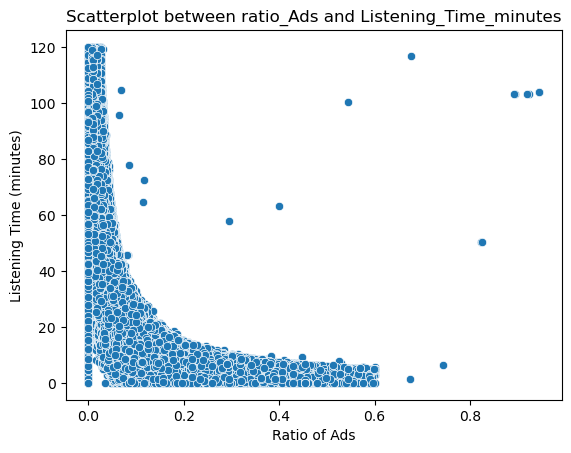

In [52]:
sns.scatterplot(data=df, x='ratio_Ads', y='Listening_Time_minutes')
plt.title('Scatterplot between ratio_Ads and Listening_Time_minutes')
plt.xlabel('Ratio of Ads')
plt.ylabel('Listening Time (minutes)')
plt.show()

# Data Preparation and Model

In [53]:
# Import TabPFN
from tabpfn import TabPFNRegressor


In [54]:

# Prepare data
X = df.drop(columns=['id', 'Listening_Time_minutes'])
Y = df['Listening_Time_minutes']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Sampling Method,found n_esttimator=32 and 8 is the same

In [55]:
# Set seed for reproducibility
np.random.seed(42)

# Determine sample size
sample_size = 10000

# Randomly select indices
sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)

# Subset the data
X_train_sampled = X_train.iloc[sample_indices]
Y_train_sampled = Y_train.iloc[sample_indices]
# Initialize and train TabPFNRegressor
model = TabPFNRegressor(n_estimators=32)
# Convert to ndarray if not already
X_train_sampled = np.asarray(X_train_sampled)
Y_train_sampled = np.asarray(Y_train_sampled)
model.fit(X_train_sampled, Y_train_sampled)

TabPFNRegressor(n_estimators=32)

In [16]:

# Make predictions in batches to avoid CUDA memory issues
X_test_processed = np.asarray(X_test)
batch_size = 1000
num_samples = X_test_processed.shape[0]
y_pred_batches = []

for i in range(0, num_samples, batch_size):
    batch_end = min(i + batch_size, num_samples)
    batch = X_test_processed[i:batch_end]
    batch_pred = model.predict(batch)
    y_pred_batches.append(batch_pred)

# Concatenate all batch predictions
y_pred = np.concatenate(y_pred_batches)

# Evaluate
Y_test = np.asarray(Y_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print(f"\nTabPFN Regression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


TabPFN Regression Results:
RMSE: 10.5875
R2 Score: 0.8484


In [57]:
# Make predictions in batches to avoid CUDA memory issues
X_test_processed = np.asarray(df_test.drop(columns = ['id']))
batch_size = 1000


In [58]:
num_samples = X_test_processed.shape[0]
y_pred_batches = []

for i in range(0, num_samples, batch_size):
    batch_end = min(i + batch_size, num_samples)
    batch = X_test_processed[i:batch_end]
    batch_pred = model.predict(batch)
    y_pred_batches.append(batch_pred)

# Concatenate all batch predictions
df_test['predict'] = np.concatenate(y_pred_batches)
df_submission = pd.DataFrame(
        {
            "id": df_test['id'],
            "Listening_Time_minutes": df_test['predict']
        }
    )

In [59]:
df_submission.to_csv('submission.csv', index=False)

In [ ]:
d

In [25]:
len(X_train)
# Set seed for reproducibility
np.random.seed(42)

# Determine sample size
sample_size = 100000

# Randomly select indices
sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)

# Subset the data
X_train_sampled = X_train.iloc[sample_indices]
Y_train_sampled = Y_train.iloc[sample_indices]
# Initialize and train TabPFNRegressor
model = TabPFNRegressor(n_estimators=32)
# Convert to ndarray if not already
X_train_sampled = np.asarray(X_train_sampled)
Y_train_sampled = np.asarray(Y_train_sampled)

In [26]:

# Train multiple TabPFN models on different subsets
n_models = 10
subset_size = 10000
models = []

for i in range(n_models):
    sampled_indices = np.random.choice(len(X_train_sampled), size=subset_size, replace=False)
    X_subset = X_train_sampled[sampled_indices]
    y_subset = Y_train_sampled[sampled_indices]
    
    model = TabPFNRegressor(n_estimators=8)
    model.fit(X_subset, y_subset)
    models.append(model)

# For prediction, average the predictions from all models
def predict(X_test):
    predictions = np.array([model.predict(X_test) for model in models])
    return np.mean(predictions, axis=0)

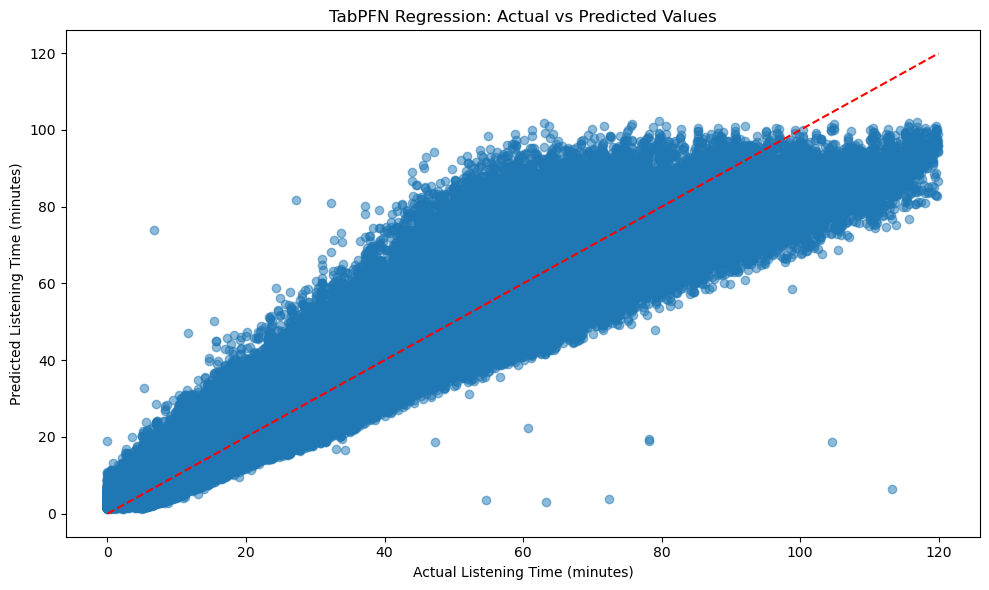

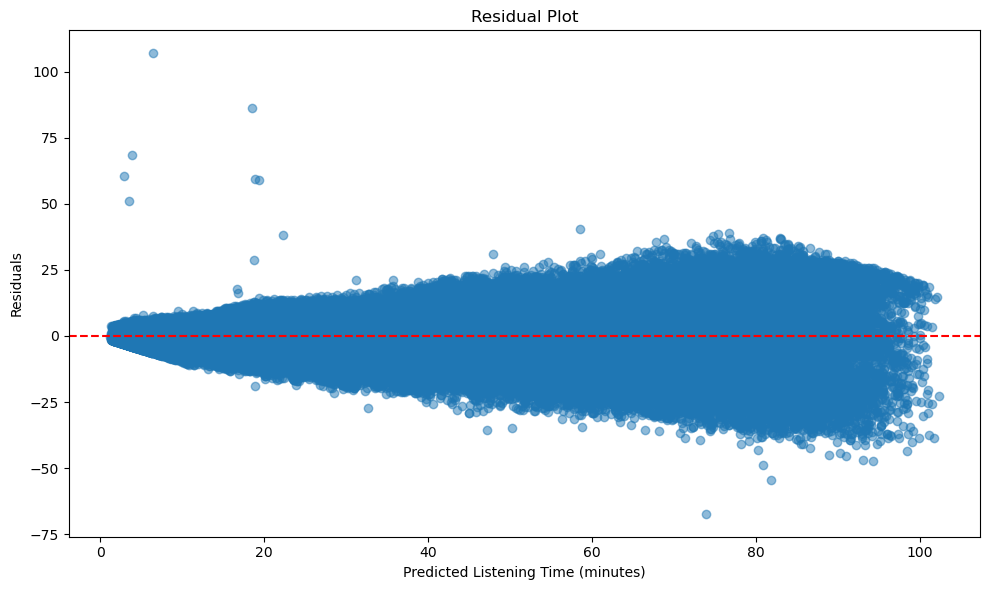

In [28]:


# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('Actual Listening Time (minutes)')
plt.ylabel('Predicted Listening Time (minutes)')
plt.title('TabPFN Regression: Actual vs Predicted Values')
plt.tight_layout()
plt.show()

# Plot residuals
residuals = Y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Listening Time (minutes)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

Mulitple Local TabPFN with Kmeans

In [52]:
# Convert to ndarray if not already
X_train_sampled = np.asarray(X_train)
Y_train_sampled = np.asarray(Y_train)

In [53]:
from sklearn.preprocessing import OrdinalEncoder

# Function to process data and handle string columns
def process_data(X_data):
    encoder = None
    
    # Check if X_data is a DataFrame or ndarray
    if isinstance(X_data, pd.DataFrame):
        # If it's a DataFrame, we can easily identify string columns
        string_cols = X_data.select_dtypes(include=['object', 'string']).columns.tolist()
        
        # Create a copy to avoid modifying the original
        X_processed = X_data.copy()
        
        # Apply ordinal encoding to string columns
        if string_cols:
            encoder = OrdinalEncoder()
            X_processed[string_cols] = encoder.fit_transform(X_processed[string_cols])
        
        # Convert to numpy array
        X_processed = X_processed.to_numpy()
    else:
        # If it's already a numpy array, we need to identify string columns differently
        # First convert to DataFrame to identify string columns
        X_df = pd.DataFrame(X_data)
        
        # Identify columns that contain strings
        string_cols = []
        for col in X_df.columns:
            if X_df[col].dtype == 'object' or X_df[col].dtype == 'string':
                string_cols.append(col)
        
        # Apply ordinal encoding to string columns
        if string_cols:
            encoder = OrdinalEncoder()
            X_df[string_cols] = encoder.fit_transform(X_df[string_cols])
        
        # Convert back to numpy array
        X_processed = X_df.to_numpy()
    
    return X_processed, encoder

# Process training data
X_train_sampled, train_encoder = process_data(X_train_sampled)
print(f"Processed X_train_sampled shape: {X_train_sampled.shape}")
print(f"Data type after processing: {type(X_train_sampled)}")

# Process test data
X_test_processed, _ = process_data(X_test)
print(f"Processed X_test shape: {X_test_processed.shape}")


Processed X_train_sampled shape: (431239, 10)
Data type after processing: <class 'numpy.ndarray'>
Processed X_test shape: (107810, 10)


In [54]:
from sklearn.cluster import KMeans

# 1. Cluster your data
kmeans = KMeans(n_clusters=48, random_state=42)  # Create 48 clusters
clusters = kmeans.fit_predict(X_train_sampled)  # X is your feature matrix

# 2. Train one TabPFN model per cluster
models = {}
for cluster_id in range(48):
    # Sample up to 10,000 points from each cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_size = min(10000, len(cluster_indices))
    sampled_indices = np.random.choice(cluster_indices, size=sample_size, replace=False)
    
    # Use direct indexing for numpy arrays instead of iloc
    X_cluster = X_train_sampled[sampled_indices]
    y_cluster = Y_train_sampled[sampled_indices]
    
    model = TabPFNRegressor()
    model.fit(X_cluster, y_cluster)
    models[cluster_id] = model

# 3. Use appropriate model for prediction
def predict(X_new):
    # Find which cluster the new data belongs to
    cluster_id = kmeans.predict(X_new)[0]
    # Use the corresponding model
    return models[cluster_id].predict(X_new)

In [55]:
# Make predictions in batches to avoid CUDA memory issues
X_test_processed = np.asarray(X_test_processed)
batch_size = 1000
num_samples = X_test_processed.shape[0]
y_pred_batches = []

for i in range(0, num_samples, batch_size):
    batch_end = min(i + batch_size, num_samples)
    batch = X_test_processed[i:batch_end]
    batch_pred = predict(batch)
    y_pred_batches.append(batch_pred)

# Concatenate all batch predictions
y_pred = np.concatenate(y_pred_batches)

# Evaluate
Y_test = np.asarray(Y_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print(f"\nTabPFN Regression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


TabPFN Regression Results:
RMSE: 50.7445
R2 Score: -2.4818


# My Submission

NameError: name 'grid_search' is not defined